# Analyse the future resident population

AIM: now that I have the projected population by age group till 2100, make some plots to understand how the future population will look like

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.colors as pc
import plotly.io as pio

import warnings

pio.renderers.default = 'vscode+notebook'
pd.options.plotting.backend = "plotly"
warnings.filterwarnings("ignore", category=FutureWarning)

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str

# convert default plotly colors to matplotlib
plotly_colors = pc.qualitative.Plotly
matplotlib_colors = []
for color in plotly_colors:
    r, g, b = pc.hex_to_rgb(color)
    matplotlib_colors.append((r/255, g/255, b/255))

In [2]:
# Recover data from previous notebooks
dfp=pd.read_csv("../data/pop_by_age_year.csv", index_col=0).rename(columns=int) # From Notebook#40
dfpj_long_all = pd.read_csv("../data/pop_by_age_year_proj.csv") # From Notebook#70

In [3]:
start_year = dfp.columns[0] # 2002
last_year = dfp.columns[-1] # 2023 (or later if updated)
end_year = 2100

print(f"First-last observation: Jan/{start_year} - Jan/{last_year}")
print(f"First-last prediction:  Jan/{last_year+1} - Jan/{end_year}")

scenarios = [ col for col in dfpj_long_all.columns if col.startswith("mig") ]
print("\nScenarios:")
display(scenarios)

First-last observation: Jan/2002 - Jan/2025
First-last prediction:  Jan/2026 - Jan/2100

Scenarios:


['migr double  & fert ↑ 2 in 2100',
 'migr double  & fert eq. to last',
 'migr double  & fert ↓ 0 in 2100',
 'migr average & fert ↑ 2 in 2100',
 'migr average & fert eq. to last',
 'migr average & fert ↓ 0 in 2100',
 'migr zero    & fert ↑ 2 in 2100',
 'migr zero    & fert eq. to last',
 'migr zero    & fert ↓ 0 in 2100']

In [4]:
# melt the dataframe to long format, which is easier to generate plots
df_plot = dfpj_long_all.melt(
    id_vars=["year", "age"], 
    value_vars=dfpj_long_all.columns[2:],
    var_name="scenario",
    value_name="population"
)
df_plot

,year,age,scenario,population
0,2002,0,migr double & fert ↑ 2 in 2100,523007
1,2002,1,migr double & fert ↑ 2 in 2100,529233
2,2002,2,migr double & fert ↑ 2 in 2100,528131
3,2002,3,migr double & fert ↑ 2 in 2100,518790
4,2002,4,migr double & fert ↑ 2 in 2100,515957
...,...,...,...,...
89986,2100,96,migr zero & fert ↓ 0 in 2100,107022
89987,2100,97,migr zero & fert ↓ 0 in 2100,84884
89988,2100,98,migr zero & fert ↓ 0 in 2100,67145
89989,2100,99,migr zero & fert ↓ 0 in 2100,52629


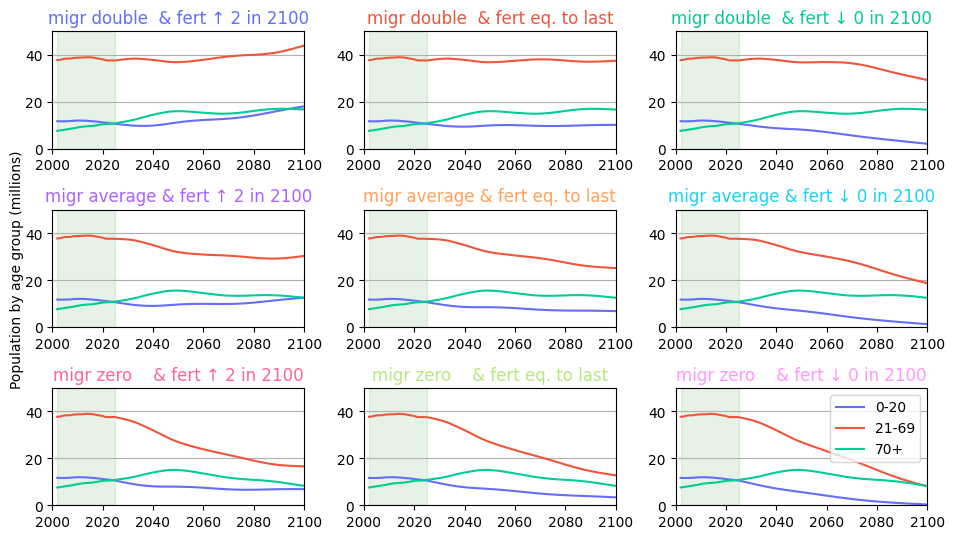

In [5]:
# Create 3x3 subplots to show the population by age group (young, adult, senior) in each scenario
AGE1, AGE2 = 20, 70

fig, axes = plt.subplots(3, 3, figsize=(9.5, 5.5), sharex=False, sharey=False)
for idx, scenario in enumerate(scenarios):
    
    ax = axes[idx // 3, idx % 3]
    df_scenario = df_plot[df_plot["scenario"] == scenario].copy()
    
    sum10 = df_scenario[df_scenario["age"].between(0, AGE1, inclusive='both')].groupby("year")["population"].sum()
    sum12 = df_scenario[df_scenario["age"].between(AGE1+1, AGE2-1, inclusive='both')].groupby("year")["population"].sum()
    sum23 =df_scenario[df_scenario["age"].between(AGE2, 100, inclusive='both')].groupby("year")["population"].sum()
    
    ax.plot(sum10.index, sum10.values/1e6, label=f"0-{AGE1}", color=matplotlib_colors[0])
    ax.plot(sum12.index, sum12.values/1e6, label=f"{AGE1+1}-{AGE2-1}", color=matplotlib_colors[1])
    ax.plot(sum23.index, sum23.values/1e6, label=f"{AGE2}+", color=matplotlib_colors[2])

    ax.set_title(scenario, color=matplotlib_colors[idx])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim(2000, end_year)
    ax.set_ylim(0, 50)
    if idx == 8:
        ax.legend()
    ax.axvspan(start_year, last_year, color="green", alpha=0.1)
    ax.grid(axis='y')

fig.text(0.0, 0.5, 'Population by age group (millions)', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("../images_output/analysis_proj_groups.png", dpi=200)
plt.show()

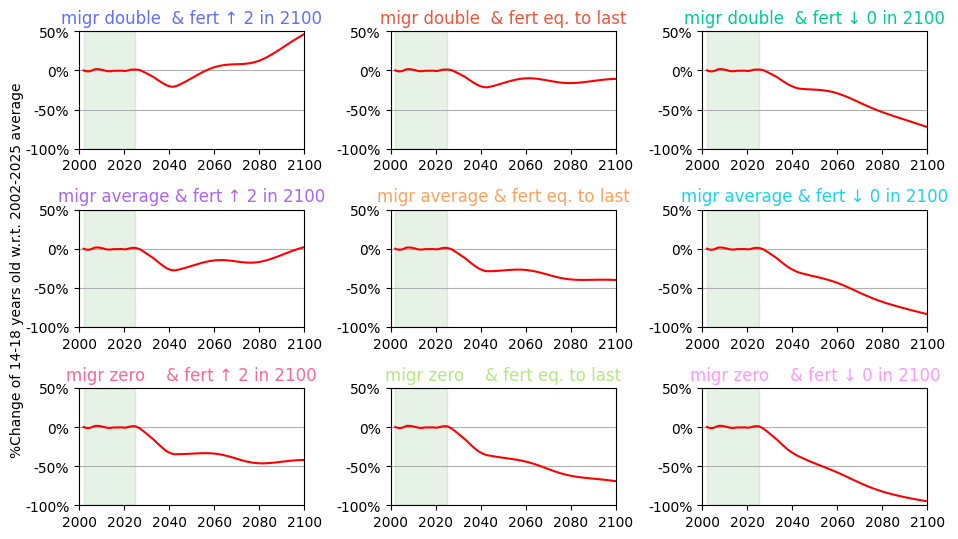

In [6]:
# Here I want to focus on the amount of teenagers in high-school age, for each of the 3x3 scenarios
AGE1, AGE2 = 14, 18

fig, axes = plt.subplots(3, 3, figsize=(9.5, 5.5), sharex=False, sharey=False)
for idx, scenario in enumerate(scenarios):
    
    ax = axes[idx // 3, idx % 3]
    df_scenario = df_plot[df_plot["scenario"] == scenario].copy()
    
    sum12 = df_scenario[df_scenario["age"].between(AGE1, AGE2, inclusive='both')].groupby("year")["population"].sum()
    avg_past = sum12[sum12.index <= last_year].mean()
    
    ax.plot(sum12.index, sum12.values/avg_past - 1, label=f"{AGE1}-{AGE2}", color="red")

    ax.set_title(scenario, color=matplotlib_colors[idx])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim(2000, end_year)
    ax.set_ylim(-1, +0.5)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.0%}"))
    ax.axvspan(start_year, last_year, color="green", alpha=0.1)
    ax.grid(axis='y')

fig.text(0, 0.5, f"%Change of {AGE1}-{AGE2} years old w.r.t. {start_year}-{last_year} average", va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("../images_output/analysis_proj_teens.png", dpi=200)
plt.show()

In [7]:
# Values from previous analysis on fertility (see Notebook #40)
fdata = json.load(open("../data/fertility_fitted.json"))
print("Fertility coefficients:")
display(fdata)

def get_newborns_next_year(dfp, year, fertility_rate, fdata):
    """Fom population and fertility rate for a given year,
    get the number of newborns for the NEXT year (fist January of year+1).
    """
    def constrained_sigmoid(x0, k):
        """Get sigmoid function, which is a cumsum of a distribution."""
        x = np.arange(17, 50+1)
        y = 1 / (1 + np.exp(-k * (x - x0)))
        y = y - y[0]
        y = y / y[-1]
        return y
    pop = dfp[year]
    mothers_potential = pop.loc[18:50].to_numpy() * fdata["assumed_women_ratio"]
    x0 = np.polyval(fdata["sigmoid_x0"], year)
    distrib = np.diff(constrained_sigmoid(x0, fdata["sigmoid_k"]))
    newborns = sum(mothers_potential * distrib) * fertility_rate
    return int(newborns)

Fertility coefficients:


{'last_observed_year': 2024,
 'last_observed_value': 1.1526289356194974,
 'sigmoid_x0': [0.09458307745702403, -159.90026614075148],
 'sigmoid_k': -0.296,
 'assumed_women_ratio': 0.5}

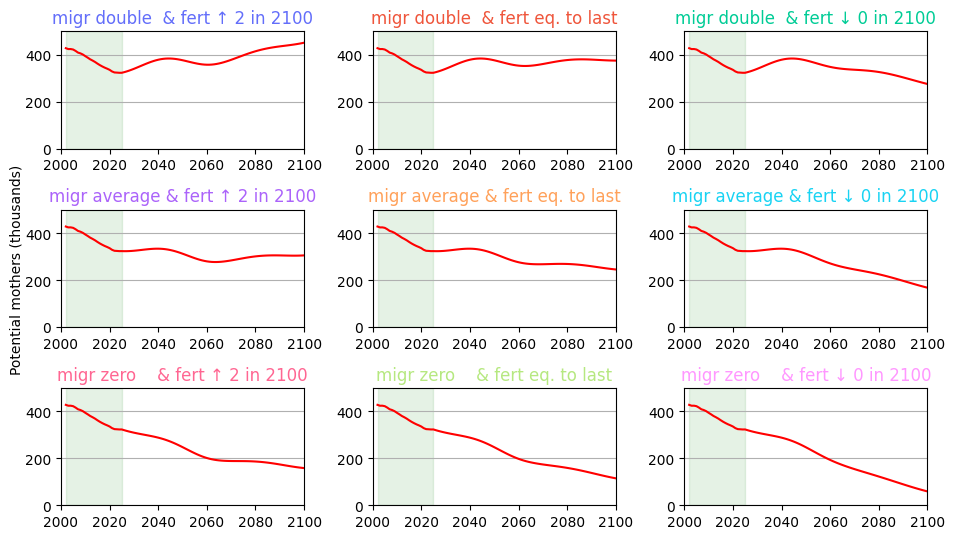

In [8]:
# Here I want to focus on the amount potential mothers, for each of the 3x3 scenarios
# This is obtained by using fertility=1 in the get_newborns_next_year function


fig, axes = plt.subplots(3, 3, figsize=(9.5, 5.5), sharex=False, sharey=False)
for idx, scenario in enumerate(scenarios):
    
    ax = axes[idx // 3, idx % 3]
    dfp_scenario = dfpj_long_all[["age", "year", scenario]].pivot(index="age", columns="year", values=scenario)
    
    value = [ get_newborns_next_year(dfp_scenario, year, 1, fdata)/1e3 for year in dfp_scenario.columns ]
    ax.plot(dfp_scenario.columns, value, color="red")

    ax.set_title(scenario, color=matplotlib_colors[idx])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xlim(2000, end_year)
    ax.set_ylim(0, 500)
    ax.axvspan(start_year, last_year, color="green", alpha=0.1)
    ax.grid(axis='y')

fig.text(0.0, 0.5, 'Potential mothers (thousands)', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("../images_output/analysis_proj_mothers.png", dpi=200)
plt.show()

## Conclusions

- TODO
  
## Follow-up

- TODO